### Laboratorio 5 
Stefano Aragoni, Carol Arevalo

Parte 1: Preparación de Datos

In [37]:
import pandas as pd
import numpy as np

# Cargue los datos en un DataFrame de Pandas
data = pd.read_csv('UK_foods.csv')

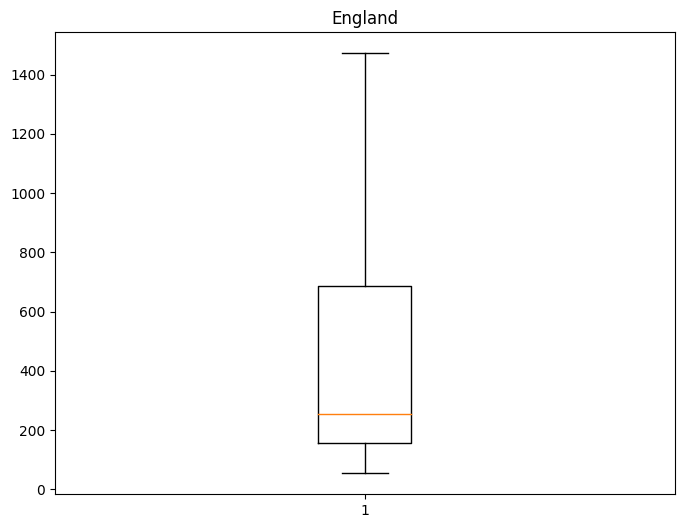

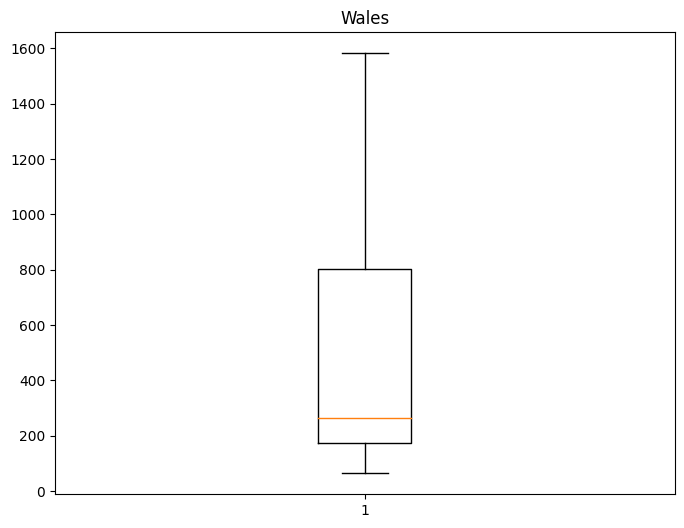

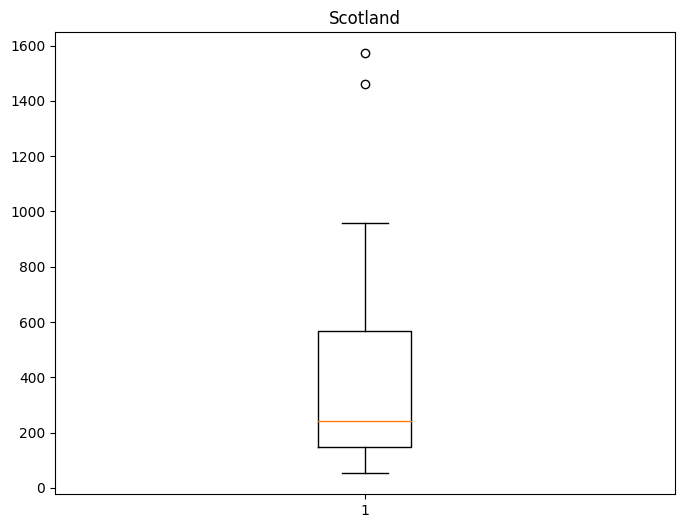

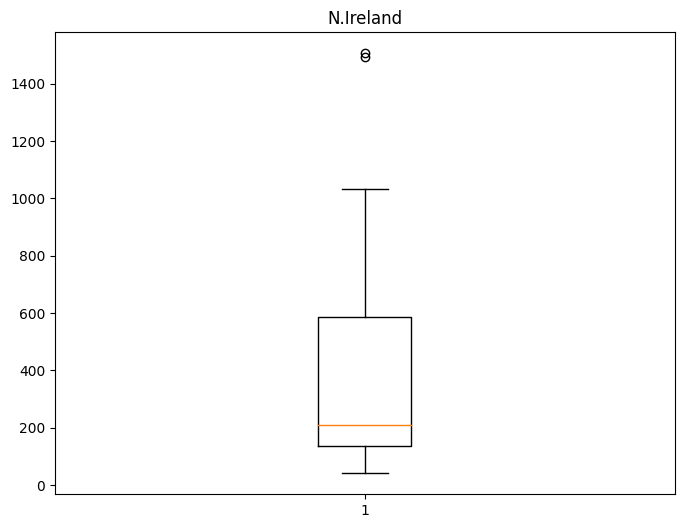

In [38]:
import matplotlib.pyplot as plt

# Visualizar valores atípicos con gráficos de caja
numeric_data = data.select_dtypes(include=[np.number])
for column in numeric_data.columns:
    plt.figure(figsize=(8, 6))
    plt.title(column)
    plt.boxplot(numeric_data[column])
    plt.show()

Valores faltantes por columna:
Unnamed: 0    0
England       0
Wales         0
Scotland      0
N.Ireland     0
dtype: int64


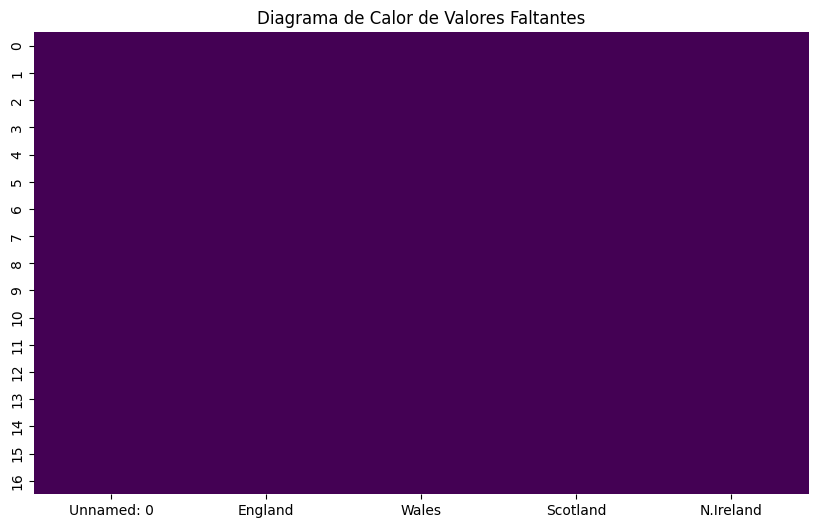

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Verificar si hay valores faltantes
missing_values = data.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

# Crear un mapa de calor para visualizar valores faltantes
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Diagrama de Calor de Valores Faltantes')
plt.show()


In [40]:
# Estadísticas descriptivas detalladas
detailed_stats = numeric_data.describe(percentiles=[0.25, 0.5, 0.75])
print("Estadísticas descriptivas detalladas:")
print(detailed_stats)

Estadísticas descriptivas detalladas:
           England        Wales     Scotland    N.Ireland
count    17.000000    17.000000    17.000000    17.000000
mean    469.647059   503.941176   460.235294   429.941176
std     452.701466   463.859282   469.595907   479.896014
min      54.000000    64.000000    53.000000    41.000000
25%     156.000000   175.000000   147.000000   135.000000
50%     253.000000   265.000000   242.000000   209.000000
75%     685.000000   803.000000   566.000000   586.000000
max    1472.000000  1582.000000  1572.000000  1506.000000


In [41]:
correlation_matrix = data.corr()

C:\Users\carev\AppData\Local\Temp\ipykernel_5360\2558734126.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [42]:
# Obtener las columnas con correlación más alta entre sí
correlation_threshold = 0.7
highly_correlated_cols = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_cols.add(colname)

# Crear un nuevo DataFrame con las columnas seleccionadas
selected_data = data[list(highly_correlated_cols)]

# Asignar los nombres de las columnas seleccionadas al nuevo DataFrame
selected_data.columns = list(highly_correlated_cols)

In [43]:
# Normalizar los datos
scaler = StandardScaler()
normalized_data = scaler.fit_transform(selected_data)

Parte 2: Construcción del Autocodificador

In [44]:
from sklearn.model_selection import train_test_split


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(normalized_data, test_size=0.2, random_state=42)

Epoch 1/100


1/1 [==============================] - 2s 2s/step - loss: 1.1942 - val_loss: 0.3798
Epoch 2/100
1/1 [==============================] - 0s 90ms/step - loss: 1.1863 - val_loss: 0.3738
Epoch 3/100
1/1 [==============================] - 0s 77ms/step - loss: 1.1739 - val_loss: 0.3625
Epoch 4/100
1/1 [==============================] - 0s 75ms/step - loss: 1.1541 - val_loss: 0.3426
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 1.1245 - val_loss: 0.3116
Epoch 6/100
1/1 [==============================] - 0s 74ms/step - loss: 1.0817 - val_loss: 0.2700
Epoch 7/100
1/1 [==============================] - 0s 63ms/step - loss: 1.0231 - val_loss: 0.2169
Epoch 8/100
1/1 [==============================] - 0s 58ms/step - loss: 0.9454 - val_loss: 0.1537
Epoch 9/100
1/1 [==============================] - 0s 64ms/step - loss: 0.8466 - val_loss: 0.0880
Epoch 10/100
1/1 [==============================] - 0s 62ms/step - loss: 0.7276 - val_loss: 0.0393
Epoch 11/100
1/1 [===============

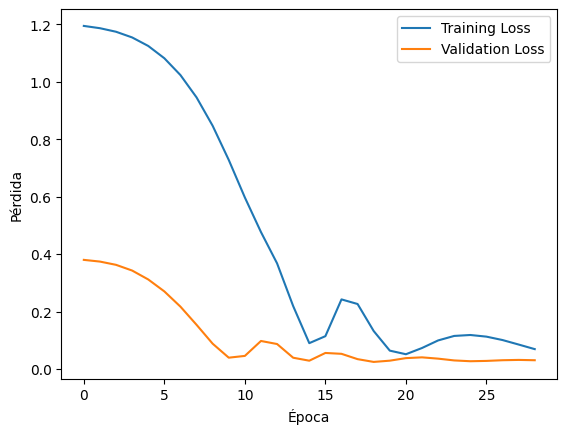

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# Definir la arquitectura del autocodificador
input_layer = Input(shape=(len(highly_correlated_cols),))
encoded = Dense(400, activation='relu')(input_layer)
encoded = Dense(200, activation='relu')(encoded)
encoded = Dense(100, activation='relu')(encoded)
encoded = Dense(50, activation='relu')(encoded)
encoded = Dense(25, activation='relu')(encoded)

decoded = Dense(50, activation='relu')(encoded)
decoded = Dense(100, activation='relu')(decoded)
decoded = Dense(200, activation='relu')(decoded)
decoded = Dense(400, activation='relu')(decoded)
decoded = Dense(len(highly_correlated_cols), activation='linear')(decoded)

# Compilar el modelo
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Configurar EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo y evaluar en el conjunto de prueba en cada época
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)


# Visualizar la pérdida en entrenamiento y prueba
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Utilizar el autocodificador para reconstruir los datos del conjunto de prueba
reconstructed_data = autoencoder.predict(X_test)

# Calcular el error de reconstrucción (puedes usar la media del error cuadrado)

reconstruction_error = mean_squared_error(X_test, reconstructed_data)
print("Error de reconstrucción en el conjunto de prueba:", reconstruction_error)


# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(X_test, reconstructed_data)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(X_test, reconstructed_data)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(X_test, reconstructed_data)

# Imprimir las métricas
print("Error cuadrático medio (MSE):", mse)
print("Error absoluto medio (MAE):", mae)
print("Coeficiente de determinación (R2):", r2)



1/1 [==============================] - 0s 44ms/step
Error de reconstrucción en el conjunto de prueba: 0.02447955790276618
Error cuadrático medio (MSE): 0.02447955790276618
Error absoluto medio (MAE): 0.11182775394222226
Coeficiente de determinación (R2): 0.3275429003652793


Un error de reconstrucción de aproximadamente 0.0244 indica que el autoencoder está haciendo un buen trabajo al comprimir y luego descomprimir los datos, y la reconstrucción es bastante precisa en comparación con los datos originales. Asimismo el valor del MSE sugiere que la calidad de la reconstrucción es relativamente buena, pero aún hay margen de mejora.. Un MAE de 0 indicaría una reconstrucción perfecta. En este caso, el MAE es de aproximadamente 0.1118. El MAE es un poco más alto que el MSE, lo que sugiere que algunos errores individuales pueden ser mayores, pero en promedio, los errores son relativamente bajos.

Parte 3: Reducción de Dimensionalidad y Visualización 


In [47]:
# Utilizar el autocodificador para reducir las dimensiones del conjunto de datos a 2
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(normalized_data)

1/1 [==============================] - 0s 107ms/step


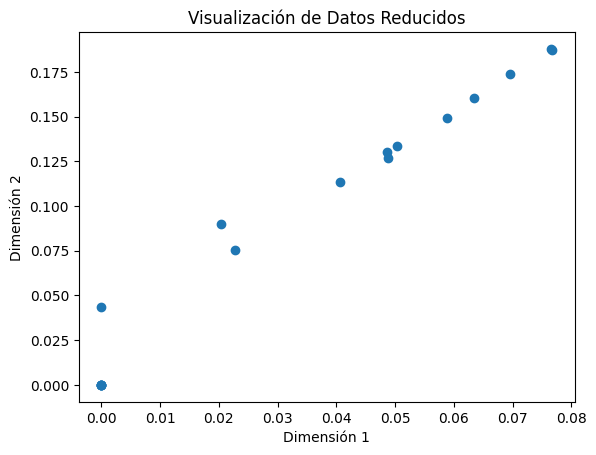

In [48]:
# Visualizar las dos dimensiones en un gráfico de dispersión
import matplotlib.pyplot as plt
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.title('Visualización de Datos Reducidos')
plt.show()

Parte 4: Discusión y percepciones nuevas "Insights" 

